## Initial Local Creation of Bayesian Network

## HC + K2

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [7]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


### Data importing and preprocessing

In [8]:
loaded_data = myData.load_data()
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, validation_data,  test_data = myData.split_data(data,num_rows = 1000)

feature_states = myData.get_feature_states(data)

c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\HC_differentScores\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced w

### Structure Learning

In [9]:
scoring_method = estimators.K2Score(data=train_data)
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))
model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())
print(model.nodes())
print(model.edges())

  8%|▊         | 8/100 [00:09<00:40,  2.28it/s]c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\estimators\StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\estimators\StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\estimators\StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * gammaln(1)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\estimators\StructureScore.py:136: RuntimeWarning: overflow encountered in scalar multiply
  (num_parents_states - counts.shape[1]) * var_cardinality * 

['loan_amnt', 'total_pymnt', 'installment', 'grade', 'title', 'int_rate', 'bc_util', 'total_acc', 'num_bc_tl', 'num_rev_accts', 'open_acc', 'mo_sin_old_rev_tl_op', 'tot_cur_bal', 'emp_length', 'loan_status', 'purpose', 'addr_state', 'earliest_cr_line', 'revol_util', 'all_util', 'last_pymnt_amnt', 'total_rec_int', 'open_il_12m', 'open_il_24m', 'open_rv_24m', 'acc_open_past_24mths', 'total_rev_hi_lim', 'total_bc_limit', 'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl', 'num_op_rev_tl', 'num_tl_120dpd_2m', 'percent_bc_gt_75', 'total_bal_ex_mort', 'total_bal_il', 'term', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 'last_credit_pull_d', 'last_fico_range_high', 'collecti

88
3
['total_pymnt', 'loan_status', 'last_pymnt_amnt']


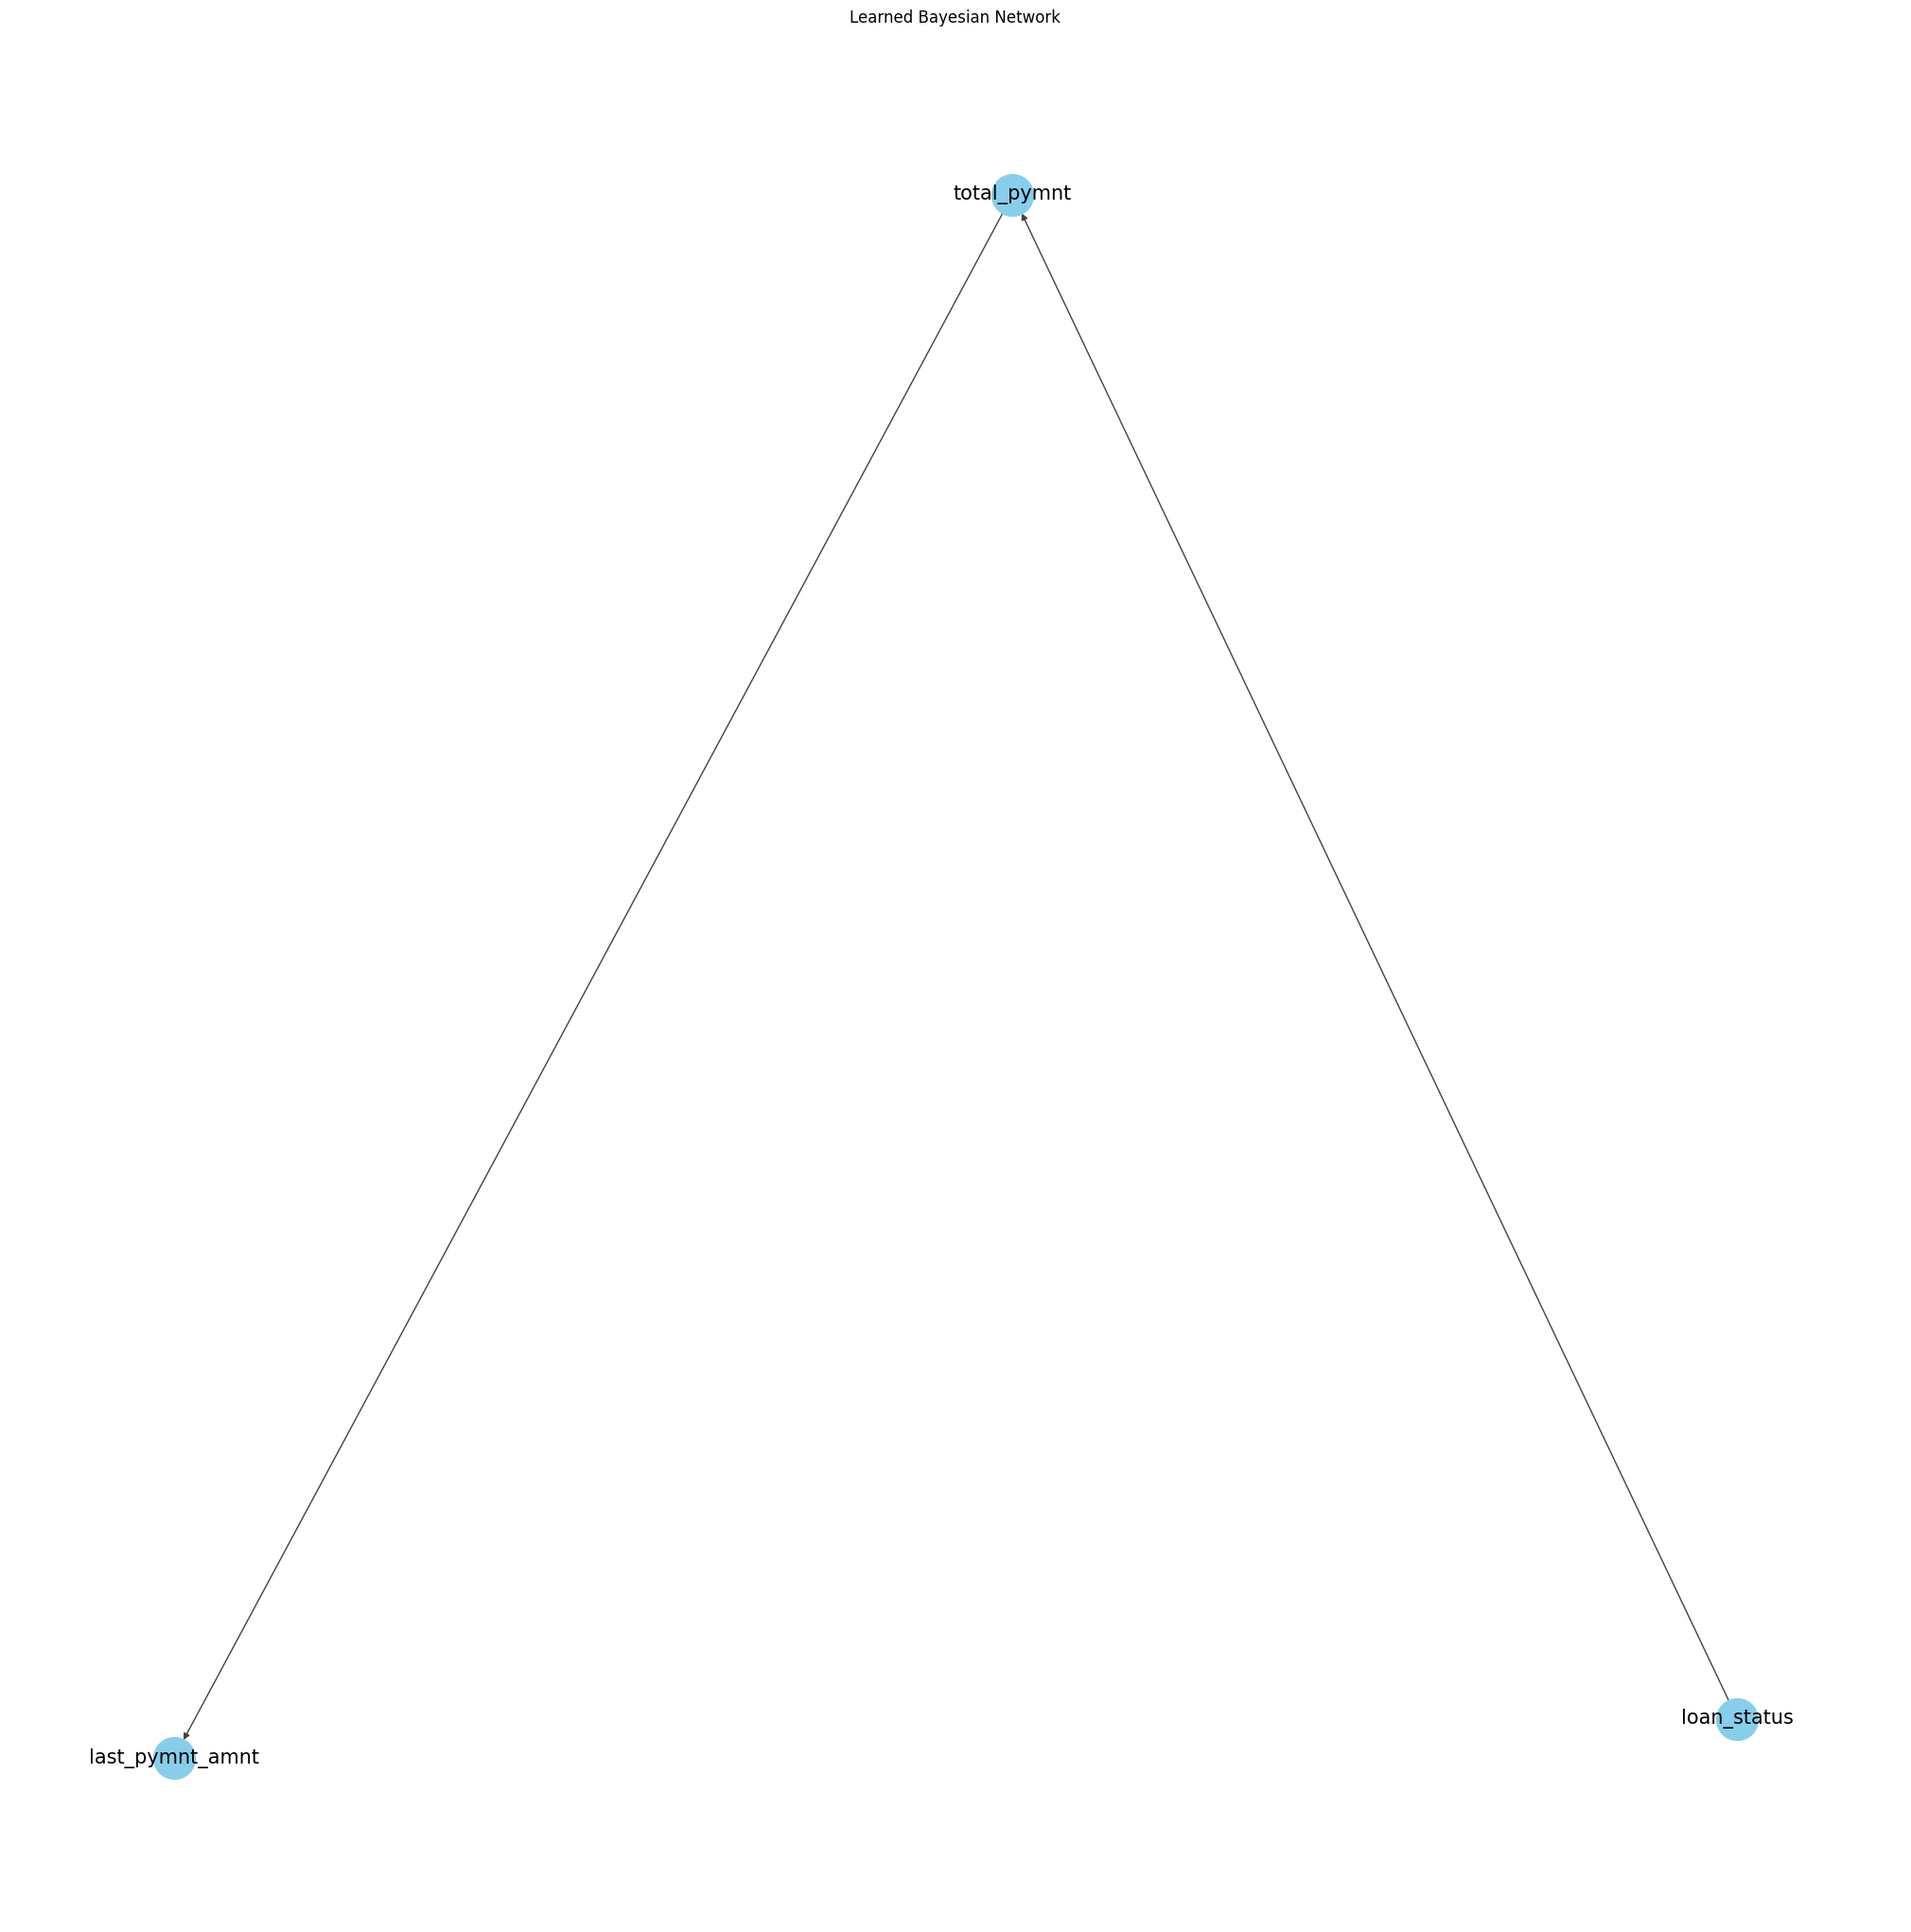

In [14]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
print(len(feature_states))
print(len(model.nodes()))
print(model.nodes())

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [15]:
parameter_estimator = estimators.BayesianEstimator(model,train_data, state_names = feature_states)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

### Inference

In [16]:
def performInference(target_label, val_test_data):
    removed_attributes = set()
    y_pred = []
    y_true = []    
    testing_evidence_list = myData.get_evidence_list(val_test_data, target_label=target_label)
    inference = VariableElimination(model)
    for i in range(len(testing_evidence_list)):
        for attribute in list(testing_evidence_list[i].keys()):
            if attribute not in model.nodes():
                removed_attributes.add(attribute)
                del testing_evidence_list[i][attribute]
    print(removed_attributes)             
    for i in range(len(testing_evidence_list)):
        loan_status = inference.map_query([target_label], evidence = testing_evidence_list[i], show_progress= True) 
        y_pred.append(loan_status[target_label])
        y_true.append(test_data[target_label].iloc[i])
    
    return y_pred, y_true
    
loan_status_y_pred, loan_status_y_true = performInference('loan_status', validation_data)    


{'last_fico_range_high', 'purpose', 'num_il_tl', 'delinq_2yrs', 'dti', 'pub_rec_bankruptcies', 'emp_length', 'home_ownership', 'avg_cur_bal', 'mort_acc', 'num_rev_accts', 'application_type', 'fico_range_high', 'tot_cur_bal', 'verification_status', 'total_bal_ex_mort', 'annual_inc', 'grade'}


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

## Testing

In [17]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)

Generating for node: last_pymnt_amnt: 100%|██████████| 3/3 [00:00<00:00, 236.49it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


correlation score: 0.0
Log likelihood score: -28408.733654058502
Structure score: -28527.61704146108
accuracy score: 0.825
f1_score: [0.         0.90410959]
precision score: [0.    0.825]
recall score: [0. 1.]
balanced_accuracy_score: 0.0



Macro scores:

recall_score_macro: 0.5
f1_score_macro: 0.4520547945205479
precision_score_macro: 0.4125


Weighted Scores:

recall_score_weighted: 0.825
f1_score_weighted: 0.7458904109589041
precision_score_weighted: 0.680625


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo